# Fraud Detection in Financial Transactions

**Candidate Name:** Hari Om  
**Assignment:** Accredian – Fraud Detection Case Study  

## Business Objective
The objective of this project is to build a machine learning model that can proactively detect fraudulent financial transactions while minimizing false positives. The insights from the model are further used to recommend actionable fraud prevention strategies.


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


## Load dataset safely (important for 6.3M rows)

## 

In [6]:
df = pd.read_csv(
    "dataset/PS_20174392719_1491204439457_log.csv",
    dtype={
        "step": "int32",
        "amount": "float32",
        "oldbalanceOrg": "float32",
        "newbalanceOrig": "float32",
        "oldbalanceDest": "float32",
        "newbalanceDest": "float32",
        "isFraud": "int8",
        "isFlaggedFraud": "int8"
    }
)

df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0


## Dataset Overview

- Total rows: ~6.3 million  
- Target variable: `isFraud`  
- Problem type: Binary Classification  
- Major challenge: Severe class imbalance (fraud cases are very rare)


In [7]:
df.isnull().sum()
df["isFraud"].value_counts(normalize=True) * 100


isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

## Feature engineering

In [8]:
df["balance_change_orig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balance_change_dest"] = df["newbalanceDest"] - df["oldbalanceDest"]

le = LabelEncoder()
df["type_encoded"] = le.fit_transform(df["type"])
df_model = df.drop(
    columns=["nameOrig", "nameDest", "type"]
)


## Train-test split

In [9]:
X = df_model.drop("isFraud", axis=1)
y = df_model["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Model training (XGBoost)

In [10]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Evaluation

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.20      0.99      0.33      1643

    accuracy                           0.99   1272524
   macro avg       0.60      0.99      0.66   1272524
weighted avg       1.00      0.99      1.00   1272524

ROC-AUC: 0.9997855770237911


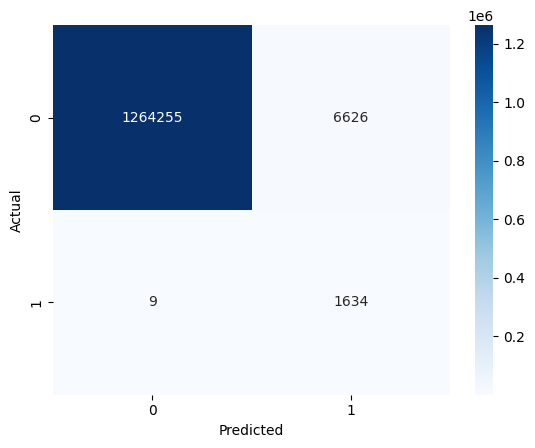

In [11]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



## Feature importance

In [12]:
importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.head(10)


balance_change_orig    0.635962
newbalanceOrig         0.112731
newbalanceDest         0.072542
amount                 0.066258
type_encoded           0.058645
oldbalanceOrg          0.020469
step                   0.011106
balance_change_dest    0.009651
isFlaggedFraud         0.007056
oldbalanceDest         0.005580
dtype: float32